In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import yfinance as yf
import mplfinance as mpf

import talib as ta

In [3]:
def get_stock_data_yf(symbol, type=None):
    stock_data = yf.Ticker(symbol)
    history = stock_data.history(period="max").sort_index()
    if type is not None:
        history = history.resample(type).agg({"Open": "first", "High": "max", "Low": "min", "Close": "last", "Volume": "sum"})
    company_name = stock_data.info["longName"]
    return history, company_name


def golden_and_dead_cross(df, col1, col2):
    df[f"{col1}>{col2}"] = df[col1] > df[col2]
    temp_gc = (df[f"{col1}>{col2}"] != df[f"{col1}>{col2}"].shift(1)) & (df[f"{col1}>{col2}"] == True)
    temp_dc = (df[f"{col1}>{col2}"] != df[f"{col1}>{col2}"].shift(1)) & (df[f"{col1}>{col2}"] == False)
    df["gc"] = [m if g == True else None for m, g in zip(df[col1], temp_gc)]
    df["dc"] = [m if d == True else None for m, d in zip(df[col2], temp_dc)]
    return df.drop(columns=[f"{col1}>{col2}"])

## Get stock data


In [5]:
data, company_name = get_stock_data_yf("AAPL")  # 2181.T ^GSPC
df = data.copy()
# -----------
n1 = 36
n2 = 41
# -----------
# SMA -------
sma_col1, sma_col2 = f"ma{n1}", f"ma{n2}"
df[sma_col1] = df["Close"].rolling(window=n1).mean()
df[sma_col2] = df["Close"].rolling(window=n2).mean()
# EMA -------
ema_col1, ema_col2 = f"ema{n1}", f"ema{n2}"
df[ema_col1] = df["Close"].ewm(span=n1, adjust=False).mean()
df[ema_col2] = df["Close"].ewm(span=n2, adjust=False).mean()

df = golden_and_dead_cross(df, ema_col1, ema_col2)
df["macd"], df["macd_signal"], df["hist"] = ta.MACD(df["Close"], fastperiod=12, slowperiod=26, signalperiod=9)

print(f"\n  >   {company_name} ")

# -----------------------
# set start and end date
# -----------------------
start = (datetime.datetime.today() - pd.DateOffset(years=1)).strftime("%Y-%m-%d")
df = df[start:]

display(df.head(3), df.tail(3))


  >   Apple Inc. 


,Open,High,Low,Close,Volume,Dividends,Stock Splits,ma36,ma41,ema36,ema41,gc,dc,macd,macd_signal,hist
Date,,,,,,,,,,,,,,,,
2023-09-25 00:00:00-04:00,173.313130,176.069032,173.263381,175.183563,46172700,0.0,0.0,177.981492,179.822522,178.921568,179.225628,NaN,NaN,-1.968678,-1.729791,-0.238886
2023-09-26 00:00:00-04:00,173.929989,174.308044,170.786073,171.084549,64588900,0.0,0.0,177.711082,179.249699,178.497946,178.837958,NaN,NaN,-2.215728,-1.826979,-0.388749
2023-09-27 00:00:00-04:00,171.741170,172.159030,168.189353,169.562317,66921800,0.0,0.0,177.485048,178.624724,178.014939,178.396261,NaN,NaN,-2.505467,-1.962676,-0.542791


,Open,High,Low,Close,Volume,Dividends,Stock Splits,ma36,ma41,ema36,ema41,gc,dc,macd,macd_signal,hist
Date,,,,,,,,,,,,,,,,
2024-09-20 00:00:00-04:00,229.970001,233.089996,227.619995,228.199997,318679900,0.0,0.0,221.693129,221.323346,221.789720,221.213128,NaN,NaN,0.526190,0.232689,0.293501
2024-09-23 00:00:00-04:00,227.339996,229.449997,225.809998,226.470001,54146000,0.0,0.0,221.925419,221.548503,222.042708,221.463456,NaN,NaN,0.753885,0.336928,0.416956
2024-09-24 00:00:00-04:00,228.649994,229.350006,225.729996,227.369995,43492700,0.0,0.0,222.141091,221.784161,222.330669,221.744720,NaN,NaN,0.995481,0.468639,0.526842


## Use Mplfinance

ref: [mplfinance](https://github.com/matplotlib/mplfinance)


Text(0.5, 1.0, 'Apple Inc. (2023-09-25 ~ )')

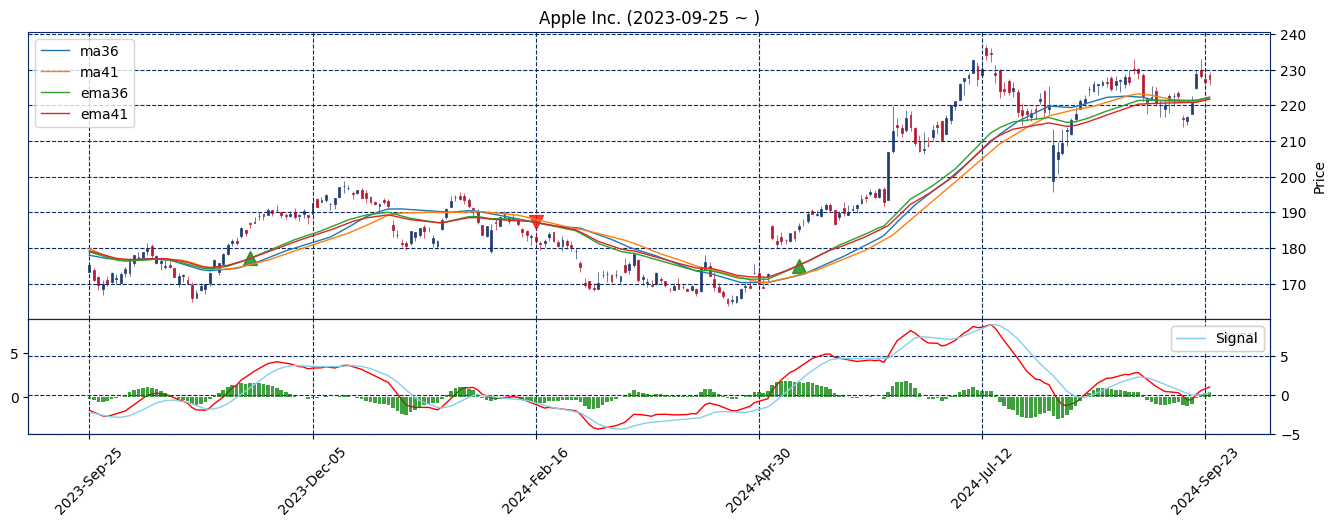

In [7]:
lines = [
    mpf.make_addplot(df[sma_col1], panel=0, width=1),
    mpf.make_addplot(df[sma_col2], panel=0, width=1),
    mpf.make_addplot(df[ema_col1], panel=0, width=1),
    mpf.make_addplot(df[ema_col2], panel=0, width=1),
    mpf.make_addplot(df["gc"], type="scatter", markersize=100, marker="^", color="g", panel=0, alpha=0.75),
    mpf.make_addplot(df["dc"], type="scatter", markersize=100, marker="v", color="r", panel=0, alpha=0.75),
    mpf.make_addplot(df["macd"], panel=1, width=1, color="red", label="MACD"),
    mpf.make_addplot(df["macd_signal"], panel=1, width=1, color="skyblue", label="Signal"),
    mpf.make_addplot(df["hist"], panel=1, type="bar", color="g", alpha=0.75),
]


fig, axes = mpf.plot(df, type="candle", figratio=(3, 1), addplot=lines, style="sas", returnfig=True)

axes[0].legend(axes[0].get_lines()[-4:], [sma_col1, sma_col2, ema_col1, ema_col2], loc="best")
axes[2].legend(axes[2].get_lines()[-2:], ["MACD", "Signal"], loc="best")
axes[0].set_title(f"{company_name} ({start} ~ )")

## Use Plotly

ref: [plotly](https://plotly.com/python/time-series/)


In [5]:
import plotly.express as px
import pandas as pd

fig = px.line(df, x=df.index, y=["Close"], title=f"{company_name} Close Price")

fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list(
            [
                dict(count=1, label="1m", step="month", stepmode="backward"),
                dict(count=6, label="6m", step="month", stepmode="backward"),
                dict(count=12, label="12m", step="month", stepmode="backward"),
                dict(count=1, label="YTD", step="year", stepmode="todate"),
                dict(count=1, label="1y", step="year", stepmode="backward"),
                dict(step="all"),
            ]
        )
    ),
)

fig.show()

# save png
# with open("stock_chart1.png", "wb") as f:
#     fig.write_image(f)

![stock_chart1](./stock_chart1.png)


In [6]:
fig = px.line(df, x=df.index, y=["Close", "ma05", "ma25"], title=f"{company_name} Close Price")
fig.add_scatter(x=df.index, y=df["gc"], mode="markers", name="Golden Cross", marker=dict(color="green", size=15, opacity=0.8), marker_symbol="triangle-up")
fig.add_scatter(x=df.index, y=df["dc"], mode="markers", name="Dead Cross", marker=dict(color="red", size=15, opacity=0.8), marker_symbol="triangle-down")

# --------------------------------
fig.update_layout(
    xaxis=dict(range=[df.index[0], df.index[-1]]),
    autosize=True,
)

fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list(
            [
                dict(count=1, label="1m", step="month", stepmode="backward"),
                dict(count=6, label="6m", step="month", stepmode="backward"),
                dict(count=12, label="12m", step="month", stepmode="backward"),
                dict(count=1, label="YTD", step="year", stepmode="todate"),
                dict(count=1, label="1y", step="year", stepmode="backward"),
                dict(step="all"),
            ]
        )
    ),
)

fig.show()

# save png
# with open("stock_chart2.png", "wb") as f:
#     fig.write_image(f)

![stock_chart2](./stock_chart2.png)
